![](https://s23209.pcdn.co/wp-content/uploads/2016/04/5MinuteAvocadoToastIMG_8273edit-600x900.jpg?p=22555)
# Avocado prices are on the rise over the past decade 
Avocado has become the world's most trendest fruit. This superfood is now a mainstay for foodies everywhere and the millenials love it more than anyone! However, have you noticed your avocado toast seems to be getting more and more expensive? Avocado prices have increased sharply to up to 129%, with an average price of a Hass avocado reaching a price of $2.10 in 2019, almost doubling in a span of one year.

Here, we will perform an exploratory data analysis and create a model to predict future prices.

## Importing required packages

In [269]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## Importing dataset into notebook and create an overview of data

In [270]:
def overview():
    '''
    Read a comma-separated values (csv) file into DataFrame.
    Print 5 rows of data
    Print number of rows and columns
    Print datatype for each column
    Print number of NULL/NaN values for each column
    Print summary data
    
    Return:
    data, rtype: DataFrame
    '''
    data = pd.read_csv('../input/avocado-prices/avocado.csv')
    print("The first 5 rows if data are:\n", data.head())
    print("\n")
    print("The (Row,Column) is:\n", data.shape)
    print("\n")
    print("Data type of each column:\n", data.dtypes)
    print("\n")
    print("The number of null values in each column are:\n", data.isnull().sum())
    print("\n")
    print("Summary of all the test scores:\n", data.describe())
    return data

df = overview()

The first 5 rows if data are:
    Unnamed: 0        Date  AveragePrice  Total Volume     4046       4225  \
0           0  2015-12-27          1.33      64236.62  1036.74   54454.85   
1           1  2015-12-20          1.35      54876.98   674.28   44638.81   
2           2  2015-12-13          0.93     118220.22   794.70  109149.67   
3           3  2015-12-06          1.08      78992.15  1132.00   71976.41   
4           4  2015-11-29          1.28      51039.60   941.48   43838.39   

     4770  Total Bags  Small Bags  Large Bags  XLarge Bags          type  \
0   48.16     8696.87     8603.62       93.25          0.0  conventional   
1   58.33     9505.56     9408.07       97.49          0.0  conventional   
2  130.50     8145.35     8042.21      103.14          0.0  conventional   
3   72.58     5811.16     5677.40      133.76          0.0  conventional   
4   75.78     6183.95     5986.26      197.69          0.0  conventional   

   year  region  
0  2015  Albany  
1  2015  Alba

- There is around 18k rows of data, with 13 variables to analyse. 
- No null values observed.
- Numerical columns (4046, 4225 and 4770) represent small hass, large hass and extra large hass. We may want to change the column labels to prevent confusion. 

### Changing column names and dropping redundant columns

In [271]:
df = df.rename(columns={'4046': "Small_Hass", '4225': "Large_Hass", '4770': "Extra_Large_Hass"})
df = df.drop(columns=['Unnamed: 0'])

# Exploratory data analysis 

## Overall price distribution

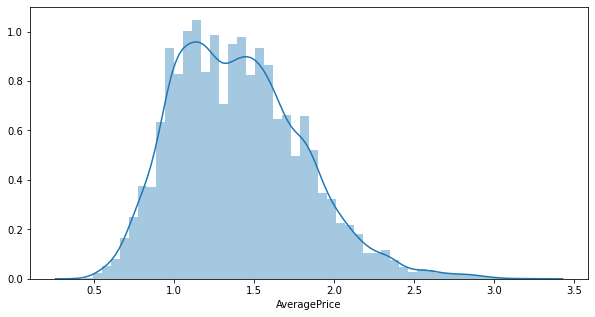

In [272]:
plt.figure(figsize=(10,5))

sns.distplot(df['AveragePrice'])

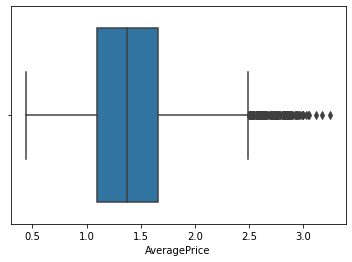

In [273]:
sns.boxplot(data = df, x = 'AveragePrice')

- We can see that the average price fluctuates around 1.00 and 2.00. Looking into our summary we can see that the mean price is around 1.41. 
- We can see a cluster of outliers present after the price of 2.5. We can get rid of the outlier by getting the 99th percentile and keeping the data below it or we can use Z-score to remove any outliers that have scores that ae greater than or less than 3 or -3 respectively. This will be done before we implement our model. 

## Comparing prices of different types of avocado between the years

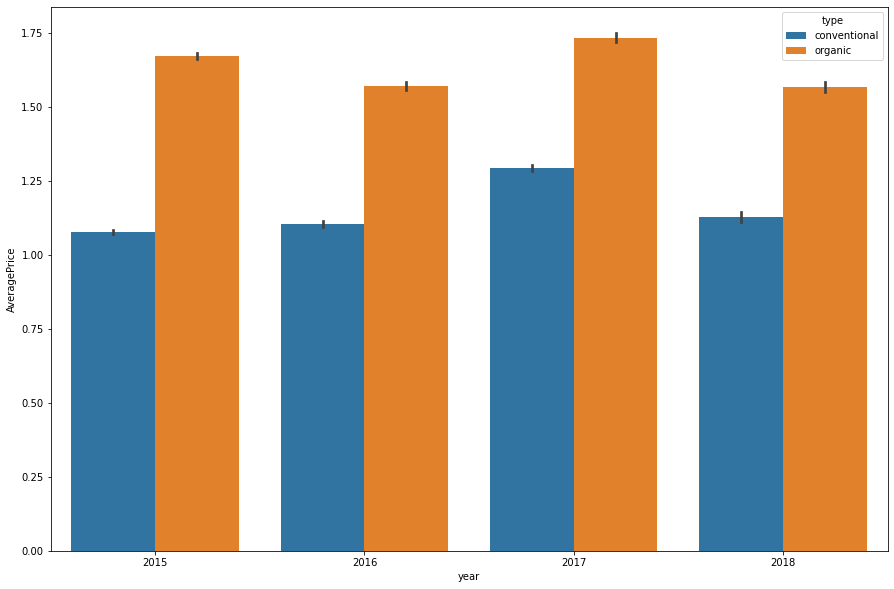

In [274]:
plt.figure(figsize=(15,10))
sns.barplot(x = 'year', y = 'AveragePrice', hue = 'type', data = df)

- First, we can see that organic avocado are definitely more expensive than conventional avocado. 
- We can see prices of avocado increasing from 2015 to 2017 before falling back to similar prices in 2016.

## Avocado prices in different regions

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:3669: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



<Figure size 1080x720 with 0 Axes>

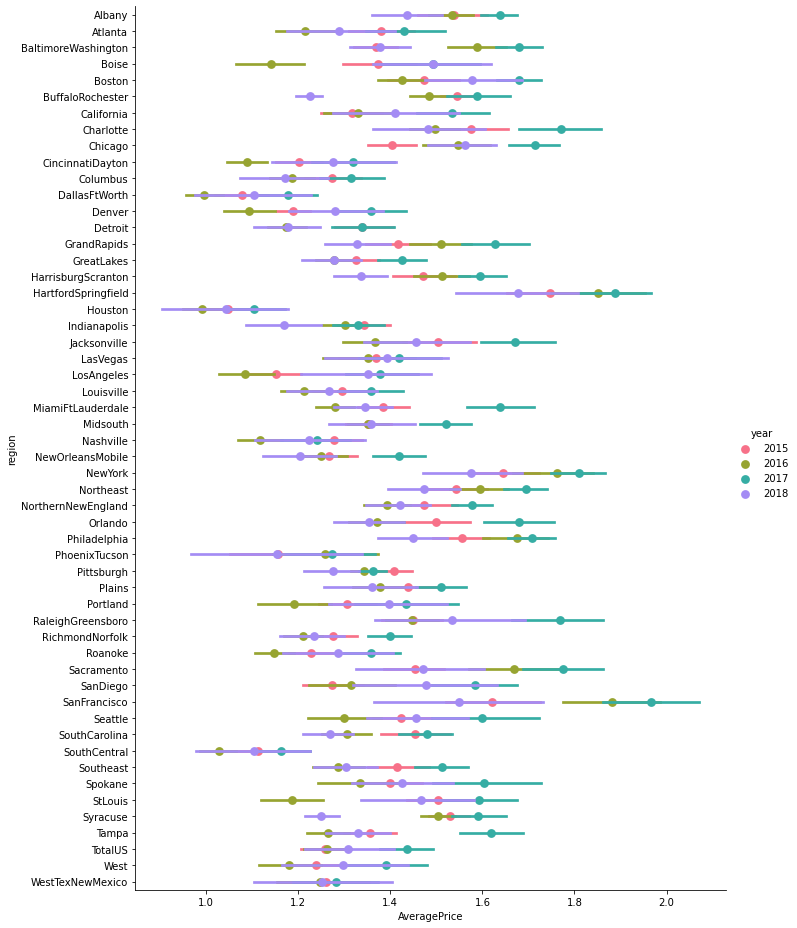

In [275]:
plt.figure(figsize=(15,10))

g = sns.factorplot('AveragePrice','region', data = df, hue='year', height = 13, aspect = 0.8, palette ='husl', join = False)

- We can see that 2017 is the year where avocado prices were the highest. It was due to a reduced harvest during that year that brought the prices up.
- Hartford Springfield seems to have the highest prices throughout the year.

## Measuring correlation 
- Before running the correlation test, we will need to convert the categorical values into numerical values using LabelEncoder.

In [276]:
le = LabelEncoder()

# Implementing LE on type
le.fit(df.type.drop_duplicates()) 
df.type = le.transform(df.type)

# Implementing LE on regions
le.fit(df.region.drop_duplicates()) 
df.region = le.transform(df.region)

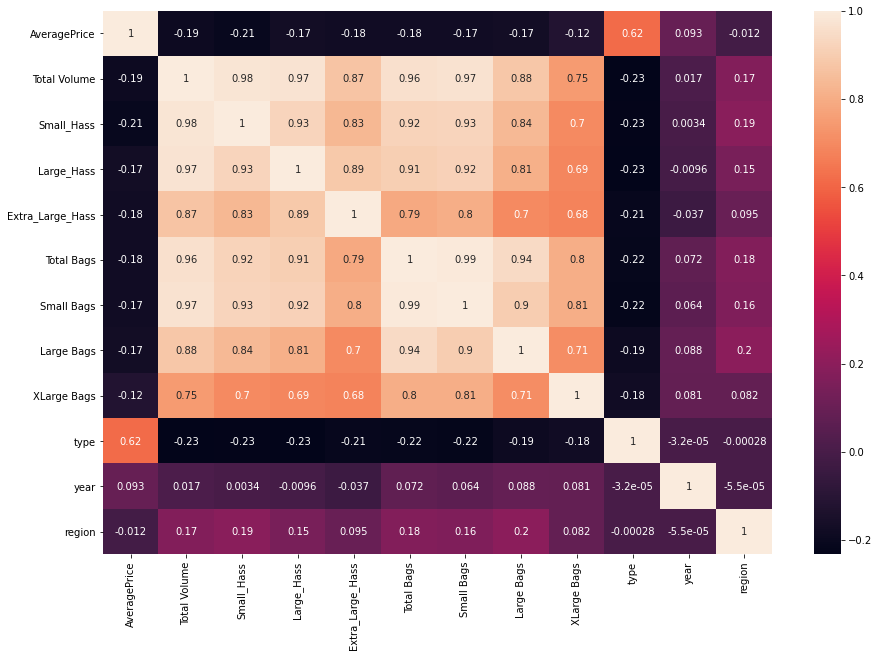

In [277]:
plt.figure(figsize=(15,10))


corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

- It seems like only type is correlated to average prices. 

# Predicting future prices of avocado using Prophet
![](https://miro.medium.com/max/964/0*tVCene42rgUTNv9Q.png)

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data.

- We will adjust yearly_seasonality to be True.
  - Seasonality is a characteristic of a time series in which the data experiences regular and predictable changes that recur every calendar year. 

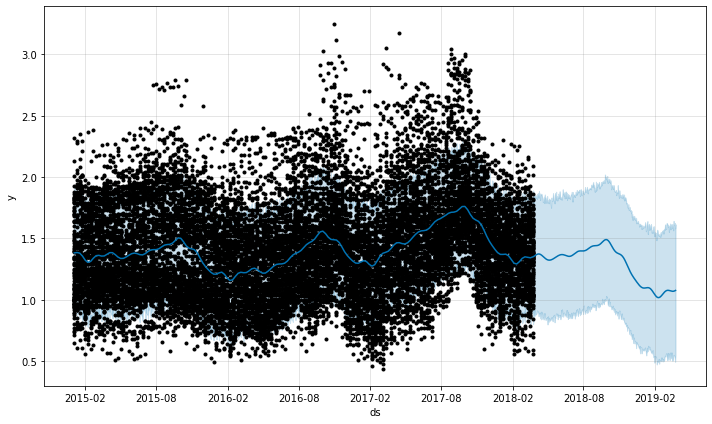

In [279]:
# Here, we will only need columns that contain the timestamp and the measure that we will like to predict 
cols = ['Date', 'AveragePrice']
df1 = df[cols]
df1.columns = ['ds', 'y']

m = Prophet()
m.fit(df1)

future = m.make_future_dataframe(periods=365)

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)

### Using Plotly to create an interactive dashboard

In [281]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)

# Performing linear regression
- Here, we will remove 'total bag', 'total volume' since we have decided to use small_hass, large_hass and extra_large_hass instead. 
    - 'total bag' and 'total volume' are highly correlated to small_hass, large_hass and extra_large_hass. We have decided to drop them since we will be using those. 
    - We will also be removing outliers by getting 99th percentile and keeping the data below it.

In [268]:
# Getting rid outliers
q = df['AveragePrice'].quantile(0.99)
df = df[df['AveragePrice']< q]


y = df['AveragePrice']
X = df[['Small_Hass', 'Large_Hass', 'Extra_Large_Hass', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year', 'region']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


lr = LinearRegression().fit(X_train,y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print(lr.score(X_test,y_test))

0.4035549425416901
